In [1]:
import cv2 
import sys 
import numpy as np 
import pandas as pd
import tensorflow as tf
import albumentations as at 
import matplotlib.pyplot as plt 

In [46]:
from IPython.display import SVG 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import to_categorical, Sequence, model_to_dot 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.layers import Activation, Dense, Input, Flatten, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D, Concatenate
from sklearn.model_selection import train_test_split 

In [22]:
def get_show_version():
    print(f"python : {sys.version}")
    print(f"numpy : {np.__version__}")
    print(f"tensorflow : {tf.__version__}")

def get_show_shape(images):
    for i in range(len(images)):
        print(images[i].shape)

def get_show_plot(images, labels, ncols=15):
    fig, axes = plt.subplots(3 , 5)
    fig.set_size_inches(12, 12)

    for i in range(ncols):
        ax = axes[i//5, i%5]
        ax.imshow(images[i], cmap="gray")
        ax.set_title(str(labels[i]))
        ax.axis("off")        
    plt.tight_layout()
    plt.show()

In [24]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# get_show_version()
# get_show_shape([train_images, train_labels])
# get_show_plot(train_images[:15], train_labels[:15], ncols=15)

In [67]:
def get_preprocessed_images(images, labels):
    images = np.array(images/255., dtype=np.float32)
    lalbes = np.array(labels, dtype=np.float32)

    return images, labels 

def get_preprocessed_one_hot_encoding(images, labels):
    images, labels = get_preprocessed_images(images, labels)
    oh_labels = to_categorical(labels)

    return images, oh_labels 

def get_train_test_valid_separate(train_images, train_labels, test_images, test_labels, train_labels_odd, test_labels_odd): 
    train_images, train_oh_labels = get_preprocessed_one_hot_encoding(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_one_hot_encoding(test_images, test_labels)

    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=2022)
    tr_images, val_images, tr_odd_labels, val_odd_labels = train_test_split(train_images, train_labels_odd, test_size=0.2, random_state =2022 )
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels), (tr_odd_labels, val_odd_labels)

def get_odd_even_separate(labels):
    labels_odd = []
    for i in labels:
        if i%2 == 0 :
            labels_odd.append(0)
        else: 
            labels_odd.append(1)
    labels_odd = np.array(labels_odd)

    return labels_odd 

In [70]:
train_labels_odd = get_odd_even_separate(train_labels)
test_labels_odd  = get_odd_even_separate(test_labels)
# get_show_shape([train_labels_odd, test_labels_odd])
# get_show_shape([train_labels, test_labels])
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels), (tr_odd_labels, val_odd_labels)= get_train_test_valid_separate(train_images, train_labels, test_images, test_labels, train_labels_odd, test_labels_odd)

get_show_shape([tr_images, tr_oh_labels, val_images, val_oh_labels, test_images, test_oh_labels, tr_odd_labels, val_odd_labels])

(48000, 28, 28)
(48000,)
(12000, 28, 28)
(12000,)
(10000, 28, 28)
(10000, 10)
(48000,)
(12000,)


In [45]:
IMAGE_SIZE = 28 

In [72]:
def set_create_model():
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="inputs")
    x = Conv2D(filters=32, kernel_size=(3,3))(input_tensor)
    x = Activation("relu")(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)

    flat_x = Flatten()(input_tensor)
    con_x = Concatenate()([x, flat_x])
    digit_output = Dense(10, activation="softmax", name="digit_output")(con_x)
    odd_output = Dense(1, activation="sigmoid", name="odd_output")(flat_x)
    model = Model(inputs = input_tensor, outputs= [digit_output, odd_output])
    model.summary()

    return model 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 26, 26, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 activation_6 (Activation)      (None, 26, 26, 32)   0           ['conv2d_6[0][0]']               
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 13, 13, 32)  0           ['activation_6[0][0]']           
                                                                                            

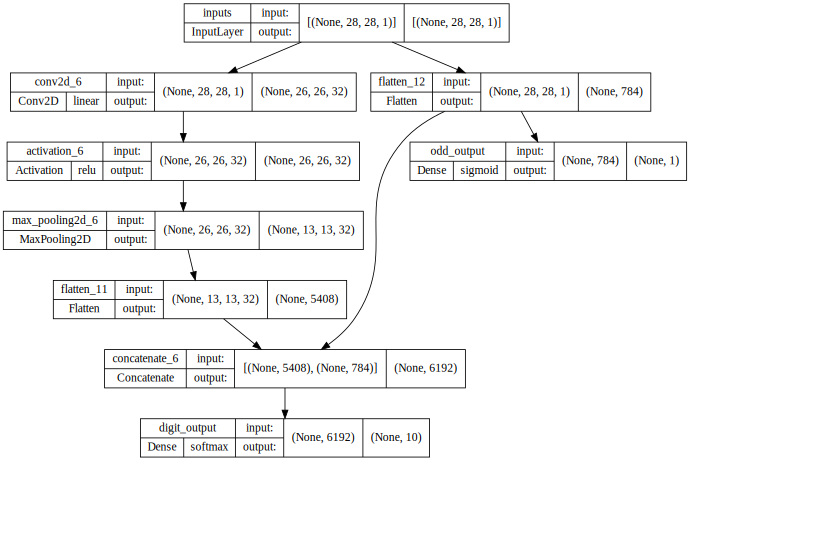

In [74]:
model = set_create_model()
SVG(model_to_dot(model, show_shapes=True, show_layer_activations=True, dpi=60).create(prog="dot", format="svg"))

In [ ]:
model.compile(optimizer=Adam(lr=0.001), 
              loss={"digit_output":"categorical_crossentropy", 
                    "odd_output":"binary_crossentropy"},
              loss_weights={"digit_output":1, 
                           "odd_output":0.5},
              metrics = ["accuracy"])

history = model.fit({'inputs': tr_images}, 
                    {'digit_output': tr_oh_labels, 
                     'odd_output': tr_odd_labels}, 
                    validation_data=({'inputs': val_images},  
                                     {'digit_output': val_oh_labels, 'odd_output': val_odd_labels}), 
                    epochs=10)